In [1]:
# we are going to load the data from the csv files in the flight data folder
# the csv file contains columns of data for each variable
# we will load the data into a dict with the key being the variable name
# and the value being a np array of the data

import numpy as np
import csv
import pandas as pd

def Rmat(phi, theta, psi):
    Rx = np.array([[1, 0, 0], [0, np.cos(phi), -np.sin(phi)], [0, np.sin(phi), np.cos(phi)]])
    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],[0, 1, 0],[-np.sin(theta), 0, np.cos(theta)]])
    Rz = np.array([[np.cos(psi), -np.sin(psi), 0],[np.sin(psi), np.cos(psi), 0], [0, 0, 1]])
    R = Rz@Ry@Rx
    return R


def load_log_file(log_file):
    # read rows of the csv file
    df = pd.read_csv(log_file)
    # convert to dictionary
    log_dict = dict()
    for key in df.columns:
        log_dict.update({key: np.array(df[key])})

    # rename the variables
    rename_dict = {
        'time': 't',
        'pos_x': 'x',
        'pos_y': 'y',
        'pos_z': 'z',
        'vel_x': 'vx',
        'vel_y': 'vy',
        'vel_z': 'vz',
        'att_phi': 'phi',
        'att_theta': 'theta',
        'att_psi': 'psi',
        'rate_p': 'p',
        'rate_q': 'q',
        'rate_r': 'r',
        'rpm_obs_1': 'w1',
        'rpm_obs_2': 'w2',
        'rpm_obs_3': 'w3',
        'rpm_obs_4': 'w4',
        'rpm_ref_1': 'u1',
        'rpm_ref_2': 'u2',
        'rpm_ref_3': 'u3',
        'rpm_ref_4': 'u4',
    }
    log_dict.update({rename_dict[key]: log_dict.pop(key) for key in rename_dict.keys()})

    # extra variables

    # u = normalized rpm commands
    log_dict['u'] = np.stack([log_dict['u1'], log_dict['u2'], log_dict['u3'], log_dict['u4']]).T
    umin = log_dict['u'].min()
    umax = log_dict['u'].max()
    log_dict['u'] = (log_dict['u']-umin)/(umax-umin)

    # vbx, vby, vbz = body frame velocity
    v_body = np.stack([
        Rmat(phi, theta, psi).T@[vx, vy, vz]
        for vx, vy, vz, phi, theta, psi
        in zip(log_dict['vx'],log_dict['vy'],log_dict['vz'],log_dict['phi'],log_dict['theta'],log_dict['psi'])
    ])
    log_dict['vbx'], log_dict['vby'], log_dict['vbz'] = v_body.T

    # abx, aby, abz = accelerometer readings body frame
    log_dict['abx'] = log_dict['ekf_U1']-log_dict['ekf_X10']
    log_dict['aby'] = log_dict['ekf_U2']-log_dict['ekf_X11']
    log_dict['abz'] = log_dict['ekf_U3']-log_dict['ekf_X12']

    return log_dict

In [3]:
import os
# list all files in flight_data folder
folder = '/mnt/c/Users/robinferede/Desktop/flight_data/ppo_network/11sep'
files = os.listdir(folder)
list(enumerate(files))

[(0, 'weird_idk.csv')]

In [5]:
index = 0
log = load_log_file(folder+'/'+files[index])
dt = log['t'][1:]-log['t'][:-1]
freq = 1/np.mean(dt)
print(freq)

503.4316743563972


In [6]:
# Define the race track
gate_pos = np.array([
    [-1.5,-2,-1.5],
    [1.5,2,-1.5],
    [1.5,-2,-2.5],
    [-1.5,2,-1.5]
]*2)

gate_yaw = np.array([
    0,
    0,
    np.pi,
    np.pi,
]*2)

gate_pos = np.array([
    [ 2,-1.5,-1.5],
    [ 2, 1.5,-1.5],
    [-2, 1.5,-1.5],
    [-2,-1.5,-1.5]
]*2)

gate_yaw = np.array([
    np.pi/4,
    3*np.pi/4,
    5*np.pi/4,
    7*np.pi/4
]*2)

In [7]:
import importlib
from quadcopter_animation import animation
importlib.reload(animation)

indices = log['autopilot_mode']>0

log_autopilot = {key: log[key][indices] for key in log.keys()}
# log_autopilot = {key: log_autopilot[key][:-3000] for key in log_autopilot.keys()}
# log_autopilot = log
log_autopilot['t'] = log_autopilot['t']-log_autopilot['t'][0]

# tx = log_autopilot['target_gate_x']
# ty = log_autopilot['target_gate_y']
# tz = log_autopilot['target_gate_z']
# target = np.array([tx, ty, tz]).T

animation.animate(**log_autopilot,
                #   target = target,
                  gate_pos=gate_pos,
                  gate_yaw=gate_yaw
                  )

QObject::moveToThread: Current thread (0x4a28e20) is not the object's thread (0x2bcbf00).
Cannot move to target thread (0x4a28e20)

QObject::moveToThread: Current thread (0x4a28e20) is not the object's thread (0x2bcbf00).
Cannot move to target thread (0x4a28e20)

QObject::moveToThread: Current thread (0x4a28e20) is not the object's thread (0x2bcbf00).
Cannot move to target thread (0x4a28e20)

QObject::moveToThread: Current thread (0x4a28e20) is not the object's thread (0x2bcbf00).
Cannot move to target thread (0x4a28e20)

QObject::moveToThread: Current thread (0x4a28e20) is not the object's thread (0x2bcbf00).
Cannot move to target thread (0x4a28e20)

QObject::moveToThread: Current thread (0x4a28e20) is not the object's thread (0x2bcbf00).
Cannot move to target thread (0x4a28e20)

QObject::moveToThread: Current thread (0x4a28e20) is not the object's thread (0x2bcbf00).
Cannot move to target thread (0x4a28e20)

QObject::moveToThread: Current thread (0x4a28e20) is not the object's thread

In [110]:
import scipy.signal as signal
import matplotlib.pyplot as plt

t = log_autopilot['t']
dt = np.mean(t[1:]-t[:-1])
freq = 1/dt
cutoff_freq = 4
sos = signal.butter(2, cutoff_freq, fs=freq, output='sos')

log_autopilot['p_filt'] = signal.sosfiltfilt(sos, log_autopilot['p'])
log_autopilot['q_filt'] = signal.sosfiltfilt(sos, log_autopilot['q'])
log_autopilot['r_filt'] = signal.sosfiltfilt(sos, log_autopilot['r'])

log_autopilot['abx_filt'] = signal.sosfiltfilt(sos, log_autopilot['abx'])
log_autopilot['aby_filt'] = signal.sosfiltfilt(sos, log_autopilot['aby'])
log_autopilot['abz_filt'] = signal.sosfiltfilt(sos, log_autopilot['abz'])

In [111]:
def first_order_delay(u, dt, tau, start=0):
    # only the first element of w will be used
    # the rest will be estimated according to the model: dw/dt = (u - w)/tau
    y = np.zeros(len(u))
    y[0] = start
    for i in range(1, len(u)):
        y[i] = y[i-1] + (u[i-1] - y[i-1]) * dt / tau
    return y

In [112]:
import matplotlib.pyplot as plt
plt.plot(log_autopilot['indi_thrust'], alpha=0.5)
model_thrust = first_order_delay(log_autopilot['indi_thrust'], dt, 0.03)
plt.plot(-log_autopilot['abz_filt'])
plt.plot(model_thrust)
plt.show()

plt.plot(log_autopilot['indi_p'], alpha=0.5)
model_p = first_order_delay(log_autopilot['indi_p'], dt, 0.03)
plt.plot(log_autopilot['p'])
plt.plot(model_p)
plt.show()

plt.plot(log_autopilot['indi_q'], alpha=0.5)
model_q = first_order_delay(log_autopilot['indi_q'], dt, 0.03)
plt.plot(log_autopilot['q'])
plt.plot(model_q)
plt.show()

plt.plot(log_autopilot['indi_r'], alpha=0.5)
model_r = first_order_delay(log_autopilot['indi_r'], dt, 0.03)
plt.plot(log_autopilot['r'])
plt.plot(model_r)
plt.show()

KeyError: 'indi_thrust'

In [113]:
import matplotlib.pyplot as plt

# waypoints = set(zip(tx,ty,tz))
# target = np.array(list(zip(tx,ty,tz)))
tx = log_autopilot['target_gate_x']
ty = log_autopilot['target_gate_y']
tz = log_autopilot['target_gate_z']
target = np.array([tx, ty, tz]).T

t = log_autopilot['t']
switches = [0]
for i in range(len(target)-1):
    if np.any(target[i]!=target[i+1]):
        switches.append(i)
# switches
switch_times = t[switches]
print(switch_times)

# lap times
lap_times = switch_times[0::4]
print(lap_times)
lap_times = lap_times[1:]-lap_times[:-1]
print(lap_times)

[ 0.        1.096655  1.934547  2.654276  3.563455  4.304661  5.122051
  5.781229  6.603496  7.229469  8.17576   9.746073 10.436502 11.296846
 11.826143 12.656221 13.065409 13.923799]
[ 0.        3.563455  6.603496 10.436502 13.065409]
[3.563455 3.040041 3.833006 2.628907]


In [114]:
# end-to-end net: 
# [3.033203 2.716789 2.887696 2.401374 3.002915 2.708984 2.821297 2.750976 2.902344 2.506836 2.499024 2.754867]
# INDI net:
# [3.18457  2.71582  2.933594 2.772461 3.193359 2.814423 3.018585 2.914063 2.875946 3.070312 3.055664 2.78711  3.065429]

In [115]:
from scipy import signal
import matplotlib.pyplot as plt

# check optitrack frequency
t = log_autopilot['t']
x_optitrack = log_autopilot['ekf_Z1']
y_optitrack = log_autopilot['ekf_Z2']
z_optitrack = log_autopilot['ekf_Z3']


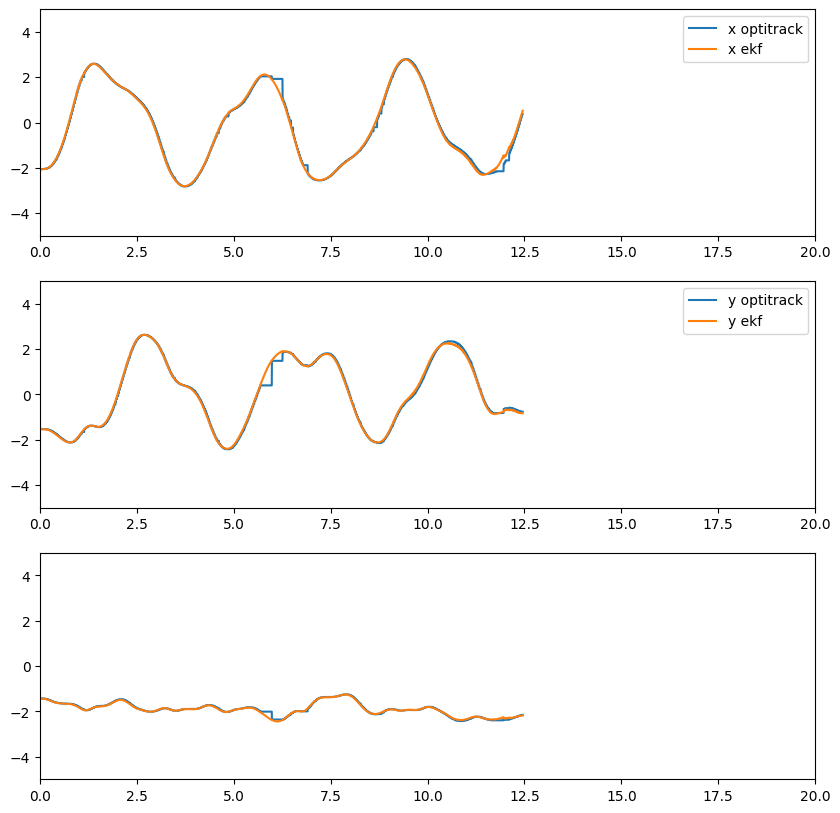

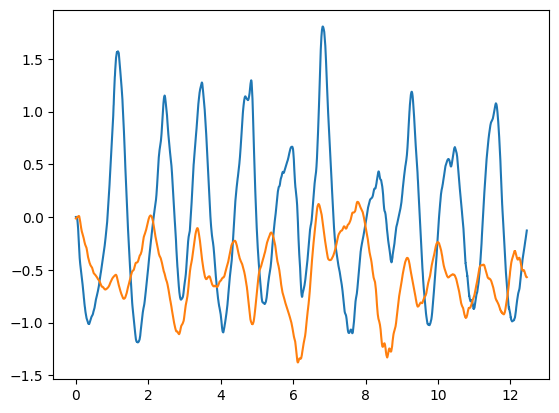

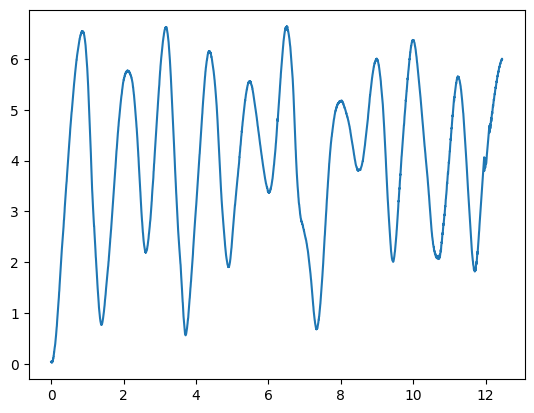

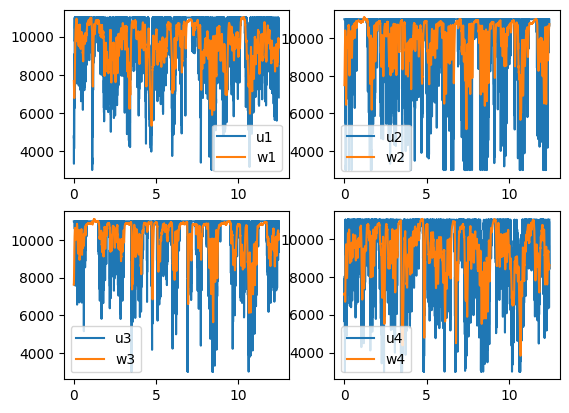

In [8]:
from scipy import signal
import matplotlib.pyplot as plt

t = log_autopilot['t']
# 3x1 plot showing comparison of ekf_Xi and ekf_Zi
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
xlim = [0,20]
ylim = [-5,5]
axs[0].plot(t, log_autopilot['ekf_Z1'], label='x optitrack')
axs[0].plot(t, log_autopilot['ekf_X1'], label='x ekf')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[0].legend()
axs[1].plot(t, log_autopilot['ekf_Z2'], label='y optitrack')
axs[1].plot(t, log_autopilot['ekf_X2'], label='y ekf')
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].legend()
axs[2].plot(t, log_autopilot['ekf_Z3'], label='z optitrack')
axs[2].plot(t, log_autopilot['ekf_X3'], label='z ekf')
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)
plt.show()

plt.plot(t, log_autopilot['phi'])
plt.plot(t, log_autopilot['theta'])
plt.show()

vx, vy, vz = log_autopilot['ekf_X4'], log_autopilot['ekf_X5'], log_autopilot['ekf_X6']
v = np.sqrt(vx**2 + vy**2 + vz**2)
plt.plot(t, v)
plt.show()

# 2x2 subplots with ui and wi plotted against t
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(t, log_autopilot['u1'], label='u1')
axs[0, 0].plot(t, log_autopilot['w1'], label='w1')
axs[0, 0].legend()
axs[0, 1].plot(t, log_autopilot['u2'], label='u2')
axs[0, 1].plot(t, log_autopilot['w2'], label='w2')
axs[0, 1].legend()
axs[1, 0].plot(t, log_autopilot['u3'], label='u3')
axs[1, 0].plot(t, log_autopilot['w3'], label='w3')
axs[1, 0].legend()
axs[1, 1].plot(t, log_autopilot['u4'], label='u4')
axs[1, 1].plot(t, log_autopilot['w4'], label='w4')
axs[1, 1].legend()
plt.show()


In [9]:
def plot_moments(traj):
    t = traj['t']
    dt = np.mean(np.gradient(t))
    freq = 1/dt
    print('dt =', dt)
    print('freq =', 1/dt)
    
    p, q, r = traj['p'], traj['q'], traj['r']
    w1, w2, w3, w4 = traj['w1'], traj['w2'], traj['w3'], traj['w4']
    
    vbx = traj['vbx']
    vby = traj['vby']
    vbz = traj['vbz']
    
    cutoff_freq = 16 #Hz
    sos = signal.butter(2, cutoff_freq, fs=freq, output='sos')

    p_ = signal.sosfiltfilt(sos, traj['p'])
    q_ = signal.sosfiltfilt(sos, traj['q'])
    r_ = signal.sosfiltfilt(sos, traj['r'])
    
    d_p = np.gradient(p_)/np.gradient(t)
    d_q = np.gradient(q_)/np.gradient(t)
    d_r = np.gradient(r_)/np.gradient(t)
    
    w1_ = signal.sosfiltfilt(sos, w1)
    w2_ = signal.sosfiltfilt(sos, w2)
    w3_ = signal.sosfiltfilt(sos, w3)
    w4_ = signal.sosfiltfilt(sos, w4)
    
    d_w1 = np.gradient(w1_)/np.gradient(t)
    d_w2 = np.gradient(w2_)/np.gradient(t)
    d_w3 = np.gradient(w3_)/np.gradient(t)
    d_w4 = np.gradient(w4_)/np.gradient(t)

    # parameters from https://arxiv.org/pdf/2304.13460.pdf
    Ix = 0.000906
    Iy = 0.001242
    Iz = 0.002054

    k_p  = 1.4119331e-09
    k_pv = -0.00797101848
    k_q  = 1.21601884e-09
    k_qv = 0.0129263739
    k_r1 = 2.57035545e-06
    k_r2 = 4.10923364e-07
    k_rr = 0.000812932607

    Mx_measured = Ix*d_p+(Iz-Iy)*q*r
    My_measured = Iy*d_q+(Ix-Iz)*p*r
    Mz_measured = Iz*d_r+(Iy-Ix)*p*q

    Mx_modeled = k_p*(w1**2-w2**2-w3**2+w4**2) + k_pv*vby
    My_modeled = k_q*(w1**2 + w2**2 - w3**2 - w4**2) + k_qv*vbx
    Mz_modeled = k_r1*(-w1+w2-w3+w4) + k_r2*(-d_w1+d_w2-d_w3+d_w4)+k_rr*(-r)

    Mx_modeled_2 = Mx_modeled + traj['Mx_nn_model']
    My_modeled_2 = My_modeled + traj['My_nn_model']
    Mz_modeled_2 = Mz_modeled + traj['Mz_nn_model']

    # 3x2 plot
    # row1 Mx_measured and Mx_modeled in the same plot | Mx_measured - Mx_modeled
    # row2 My_measured and My_modeled in the same plot | My_measured - My_modeled
    # row3 Mz_measured and Mz_modeled in the same plot | Mz_measured - Mz_modeled
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharey='col')
    fig.suptitle('Moments')

    axs[0, 0].plot(t, Mx_measured, label='Mx_measured')
    axs[0, 0].plot(t, Mx_modeled, label='Mx_modeled')
    axs[0, 0].plot(t, Mx_modeled_2, label='Mx_modeled_2')
    # axs[0, 0].plot(t, Mx_fit, label='Mx_fit')
    axs[0, 0].set_title('Mx')
    axs[0, 0].legend()

    axs[0, 1].plot(t, Mx_measured-Mx_modeled, label='Mx_measured - Mx_modeled')
    axs[0, 1].plot(t, Mx_measured-Mx_modeled_2, label='Mx_measured - Mx_modeled_2')
    axs[0, 1].plot(t, 0*t+0.04, '--k')
    axs[0, 1].plot(t, 0*t-0.04, '--k')
    # axs[0, 1].plot(t, traj['Mx_measured']-traj['Mx_modeled'], label='Mx_measured - Mx_modeled')
    # axs[0, 1].plot(t, Mx_measured-Mx_fit, label='Mx_measured - Mx_fit')
    axs[0, 1].set_title('Mx_measured - Mx_modeled')
    axs[0, 1].legend()
    # set the axis tick_params such that the y-axis tick labels are visible
    axs[0, 1].tick_params(axis='y', which='both', labelleft=True, labelright=False)

    axs[1, 0].plot(t, My_measured, label='My_measured')
    axs[1, 0].plot(t, My_modeled, label='My_modeled')
    axs[1, 0].plot(t, My_modeled_2, label='My_modeled_2')
    # axs[1, 0].plot(t, My_fit, label='My_fit')
    axs[1, 0].set_title('My')
    axs[1, 0].legend()

    axs[1, 1].plot(t, My_measured-My_modeled, label='My_measured - My_modeled')
    axs[1, 1].plot(t, My_measured-My_modeled_2, label='My_measured - My_modeled_2')
    axs[1, 1].plot(t, 0*t+0.04, '--k')
    axs[1, 1].plot(t, 0*t-0.04, '--k')
    # axs[1, 1].plot(t, traj['My_measured']-traj['My_modeled'], label='My_measured - My_modeled')
    # axs[1, 1].plot(t, vbz*(vbz>0)/30, label='vbz')
    # axs[1, 1].plot(t, My_measured-My_fit, label='My_measured - My_fit')
    axs[1, 1].set_title('My_measured - My_modeled')
    axs[1, 1].legend()
    # set the axis tick_params such that the y-axis tick labels are visible
    axs[1, 1].tick_params(axis='y', which='both', labelleft=True, labelright=False)

    axs[2, 0].plot(t, Mz_measured, label='Mz_measured')
    axs[2, 0].plot(t, Mz_modeled, label='Mz_modeled')
    axs[2, 0].plot(t, Mz_modeled_2, label='Mz_modeled_2')
    axs[2, 0].set_title('Mz')
    axs[2, 0].legend()
    
    axs[2, 1].plot(t, Mz_measured-Mz_modeled, label='Mz_measured - Mz_modeled')
    axs[2, 1].plot(t, Mz_measured-Mz_modeled_2, label='Mz_measured - Mz_modeled_2')
    axs[2, 1].plot(t, 0*t+0.01, '--k')
    axs[2, 1].plot(t, 0*t-0.01, '--k')
    axs[2, 1].set_title('Mz_measured - Mz_modeled')
    axs[2, 1].legend()
    # set the axis tick_params such that the y-axis tick labels are visible
    axs[2, 1].tick_params(axis='y', which='both', labelleft=True, labelright=False)
    
    # set xlim for all axes to [0, 5]
    for ax in axs.flat:
        ax.set_xlim([0, 5])
    plt.show()

dt = 0.0021021198312236285
freq = 475.7102735755589


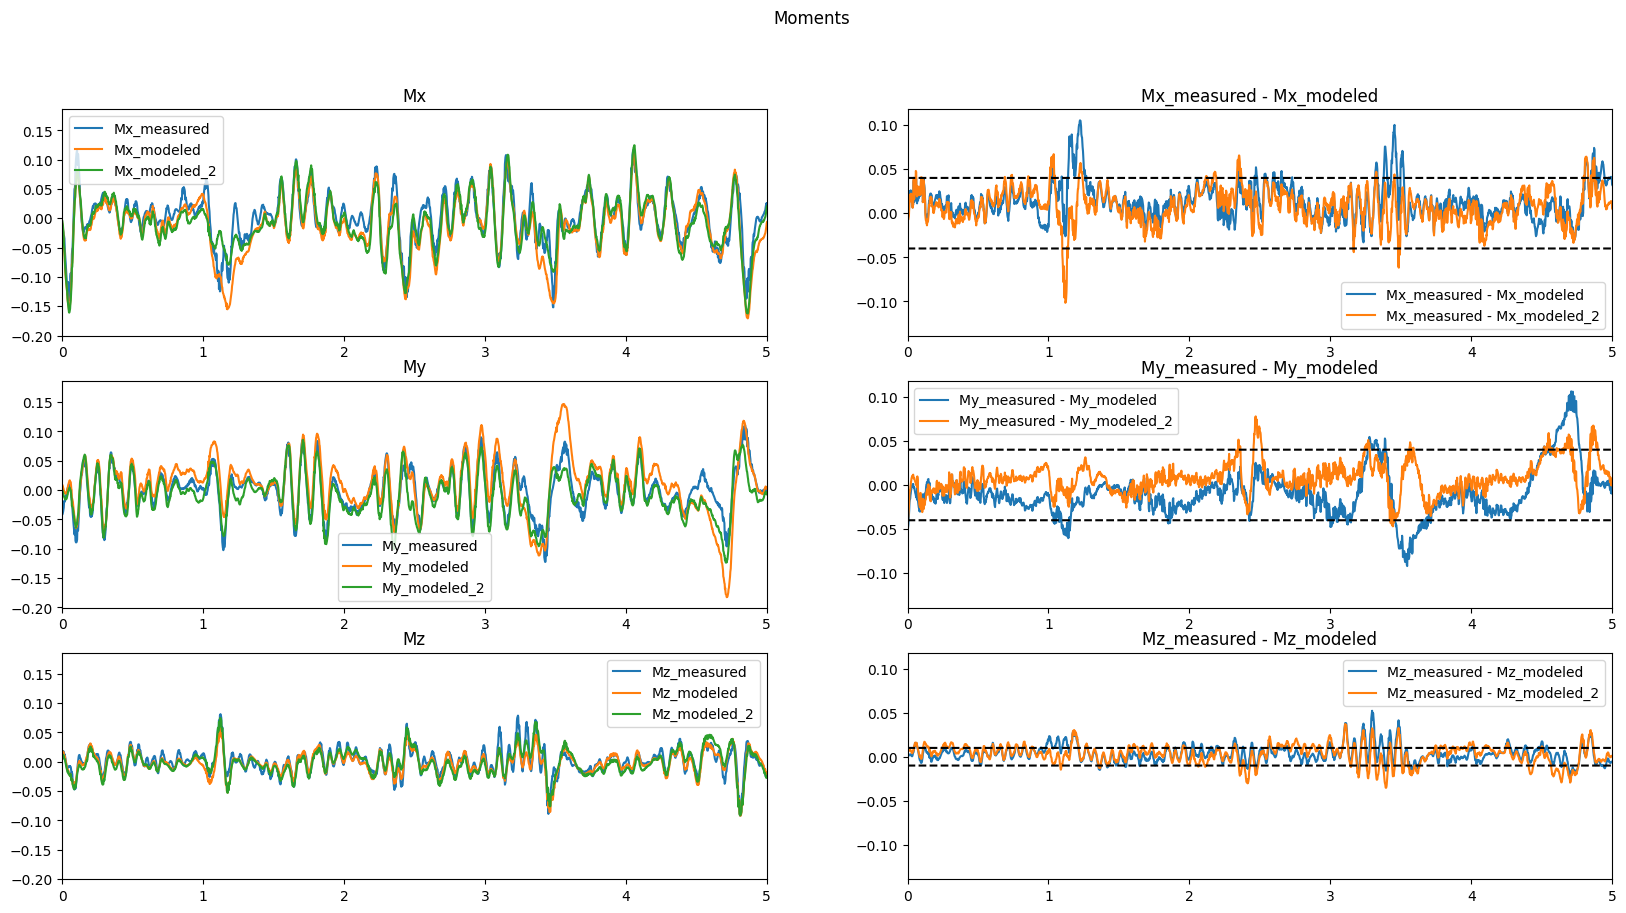

['ekf_X1', 'ekf_X2', 'ekf_X3', 'ekf_X4', 'ekf_X5', 'ekf_X6', 'ekf_X7', 'ekf_X8', 'ekf_X9', 'ekf_X10', 'ekf_X11', 'ekf_X12', 'ekf_X13', 'ekf_X14', 'ekf_X15', 'ekf_U1', 'ekf_U2', 'ekf_U3', 'ekf_U4', 'ekf_U5', 'ekf_U6', 'ekf_Z1', 'ekf_Z2', 'ekf_Z3', 'ekf_Z4', 'autopilot_mode', 'target_gate_x', 'target_gate_y', 'target_gate_z', 'Mx_measured', 'My_measured', 'Mz_measured', 'Fz_measured', 'Mx_modeled', 'My_modeled', 'Mz_modeled', 'Fz_modeled', 'Mx_nn_model', 'My_nn_model', 'Mz_nn_model', 'Fz_nn_model', 'cmd_thrust', 'cmd_roll', 'cmd_pitch', 'cmd_yaw', 't', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'phi', 'theta', 'psi', 'p', 'q', 'r', 'w1', 'w2', 'w3', 'w4', 'u1', 'u2', 'u3', 'u4', 'u', 'vbx', 'vby', 'vbz', 'abx', 'aby', 'abz']


In [10]:
# log_cut = {key: log[key][0:500] for key in log_autopilot.keys()}
plot_moments(log_autopilot)
print(list(log_autopilot.keys()))

In [11]:
def plot_thrust_drag(traj):
    t = traj['t']
    dt = np.mean(np.gradient(t))
    freq = 1/dt
    print('dt =', dt)
    print('freq =', 1/dt)

    
    vbx, vby, vbz = traj['vbx'], traj['vby'], traj['vbz']
    w1, w2, w3, w4 = traj['w1'], traj['w2'], traj['w3'], traj['w4']
    
    cutoff_freq = 16 #Hz
    sos = signal.butter(2, cutoff_freq, fs=freq, output='sos')
    
    # Measured thrust and drag
    T = signal.sosfiltfilt(sos,traj['abz'])
    Dx = signal.sosfiltfilt(sos,traj['abx'])
    Dy = signal.sosfiltfilt(sos,traj['aby'])
    
    
    # parameters from https://arxiv.org/pdf/2304.13460.pdf
    k_x  = 1.07933887e-05
    k_y  = 9.65250793e-06
    k_z  = 2.7862899e-05
    k_w  = 4.36301076e-08
    k_h  = 0.0625501332
    
    Tmod = -k_w*(w1**2+w2**2+w3**2+w4**2) - k_z*vbz*(w1+w2+w3+w4) - k_h*(vbx**2+vby**2)
    Dxmod = -k_x*vbx*(w1+w2+w3+w4)
    Dymod = -k_y*vby*(w1+w2+w3+w4)
    
    Tmod2 = Tmod + traj['Fz_nn_model']
    
    # 3x2 plot
    # row1: T and Tmod in same plot | T-Tmod
    # row2: Dx and Dxmod in same plot | Dx-Dxmod
    # row3: Dy and Dymod in same plot | Dy-Dymod
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharey='col')
    fig.suptitle('Forces')

    axs[0,0].plot(t,T,label='T')
    # axs[0,0].plot(t,traj['Fz_measured'],label='T')
    axs[0,0].plot(t,Tmod,label='Tmod')
    axs[0,0].plot(t,Tmod2,label='Tmod2')
    # axs[0,0].plot(t,traj['Fz_modeled'],label='Tmod')
    # axs[0,0].plot(t,vbz*(vbz>0),label='vbz')
    axs[0,0].set_title('Thrust')
    axs[0,0].legend()

    axs[0,1].plot(t,T-Tmod,label='T-Tmod')
    axs[0,1].plot(t,T-Tmod2,label='T-Tmod2')
    # dotted black line at 0 and 2
    axs[0,1].plot(t,0*t,'--k')
    axs[0,1].plot(t,0*t+2,'--k')
    # axs[0,1].plot(t,traj['Fz_measured']-traj['Fz_modeled'],label='T-Tmod')
    # axs[0,1].plot(t,vbz*(vbz>0),label='vbz')
    axs[0,1].set_title('T-Tmod')
    axs[0,1].legend()
    # set the axis tick_params such that the y-axis tick labels are visible
    axs[0,1].tick_params(axis='y', which='both', labelleft=True, labelright=False)

    axs[1,0].plot(t,Dx,label='Dx')
    axs[1,0].plot(t,Dxmod,label='Dxmod')
    axs[1,0].set_title('Drag X')
    axs[1,0].legend()

    axs[1,1].plot(t,Dx-Dxmod,label='Dx-Dxmod')
    axs[1,1].set_title('Dx-Dxmod')
    axs[1,1].legend()
    # set the axis tick_params such that the y-axis tick labels are visible
    axs[1,1].tick_params(axis='y', which='both', labelleft=True, labelright=False)

    axs[2,0].plot(t,Dy,label='Dy')
    axs[2,0].plot(t,Dymod,label='Dymod')
    axs[2,0].set_title('Drag Y')
    axs[2,0].legend()

    axs[2,1].plot(t,Dy-Dymod,label='Dy-Dymod')
    axs[2,1].set_title('Dy-Dymod')
    axs[2,1].legend()
    # set the axis tick_params such that the y-axis tick labels are visible
    axs[2,1].tick_params(axis='y', which='both', labelleft=True, labelright=False)
    
    # set xlim for all axes to [0, 5]
    for ax in axs.flat:
        ax.set_xlim([0, 5])
    plt.show()

dt = 0.0021021198312236285
freq = 475.7102735755589


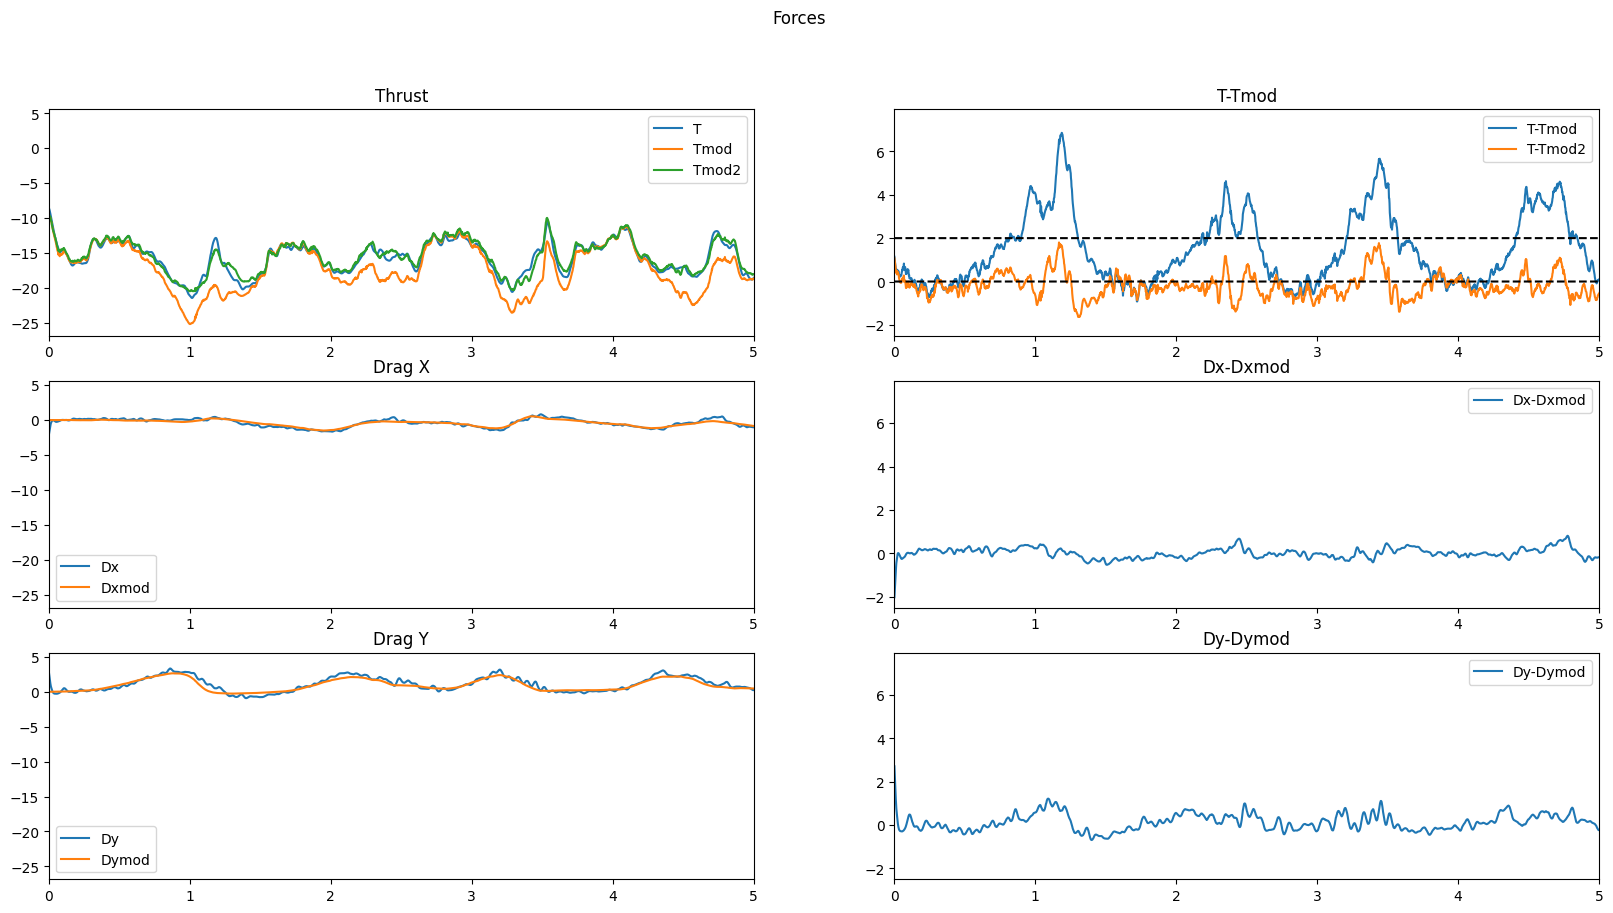

In [12]:
plot_thrust_drag(log_autopilot)

In [13]:
def w_mod(u, w, dt):
    # only the first element of w will be used
    # the rest will be estimated according to the model: dw/dt = (u - w)/tau
    w_mod = np.zeros(len(u))
    w_mod[0] = w[0]
    tau = 0.06 # from https://arxiv.org/pdf/2304.13460.pdf
    for i in range(1, len(u)):
        w_mod[i] = w_mod[i-1] + (u[i-1] - w_mod[i-1]) * dt / tau
    return w_mod


def plot_actuators(traj):
    t = traj['t']
    dt = np.mean(np.gradient(t))
    freq = 1/dt
    print('dt =', dt)
    print('freq =', 1/dt)

    u1 = traj['u1'].copy()
    u2 = traj['u2'].copy()
    u3 = traj['u3'].copy()
    u4 = traj['u4'].copy()

    # Experiment: cap u to a maximum of 11000
    # ulim = 11000
    # u1[u1 > ulim] = ulim
    # u2[u2 > ulim] = ulim
    # u3[u3 > ulim] = ulim
    # u4[u4 > ulim] = ulim

    w1 = traj['w1']
    w2 = traj['w2']
    w3 = traj['w3']
    w4 = traj['w4']

    print('w1 max =', np.max(w1))
    print('w2 max =', np.max(w2))
    print('w3 max =', np.max(w3))
    print('w4 max =', np.max(w4))

    w1_mod = w_mod(u1, w1, dt)
    w2_mod = w_mod(u2, w2, dt)
    w3_mod = w_mod(u3, w3, dt)
    w4_mod = w_mod(u4, w4, dt)

    # 4x2 plot
    # row1: w1 and w1_mod in same plot | w1-w1_mod
    # row2: w2 and w2_mod in same plot | w2-w2_mod
    # row3: w3 and w3_mod in same plot | w3-w3_mod
    # row4: w4 and w4_mod in same plot | w4-w4_mod
    fig, axs = plt.subplots(4, 2, figsize=(20, 10), sharey='col', tight_layout=True)
    fig.suptitle('Actuators')
    rpm_max_line = 10500
    axs[0, 0].plot(t, u1, label='u1', color='black', alpha=0.1)
    axs[0, 0].plot(t, w1, label='w1')
    axs[0, 0].plot(t, w1_mod, label='w1_mod')
    axs[0, 0].plot(t, t*0+rpm_max_line)
    axs[0, 0].set_title('w1 and w1_mod')
    axs[0, 0].legend()

    axs[0, 1].plot(t, w1-w1_mod)
    axs[0, 1].set_title('w1-w1_mod')

    axs[1, 0].plot(t, u2, label='u2', color='black', alpha=0.1)
    axs[1, 0].plot(t, w2, label='w2')
    axs[1, 0].plot(t, w2_mod, label='w2_mod')
    axs[1, 0].plot(t, t*0+rpm_max_line)
    axs[1, 0].set_title('w2 and w2_mod')
    axs[1, 0].legend()

    axs[1, 1].plot(t, w2-w2_mod)
    axs[1, 1].set_title('w2-w2_mod')

    axs[2, 0].plot(t, u3, label='u3', color='black', alpha=0.1)
    axs[2, 0].plot(t, w3, label='w3')
    axs[2, 0].plot(t, w3_mod, label='w3_mod')
    axs[2, 0].plot(t, t*0+rpm_max_line)
    axs[2, 0].set_title('w3 and w3_mod')
    axs[2, 0].legend()
    
    axs[2, 1].plot(t, w3-w3_mod)
    axs[2, 1].set_title('w3-w3_mod')

    axs[3, 0].plot(t, u4, label='u4', color='black', alpha=0.1)
    axs[3, 0].plot(t, w4, label='w4')
    axs[3, 0].plot(t, w4_mod, label='w4_mod')
    axs[3, 0].plot(t, t*0+rpm_max_line)
    axs[3, 0].set_title('w4 and w4_mod')
    axs[3, 0].legend()

    axs[3, 1].plot(t, w4-w4_mod)
    axs[3, 1].set_title('w4-w4_mod')

    plt.show()

dt = 0.0021021198312236285
freq = 475.7102735755589
w1 max = 11011.0
w2 max = 11099.0
w3 max = 11125.0
w4 max = 11042.0


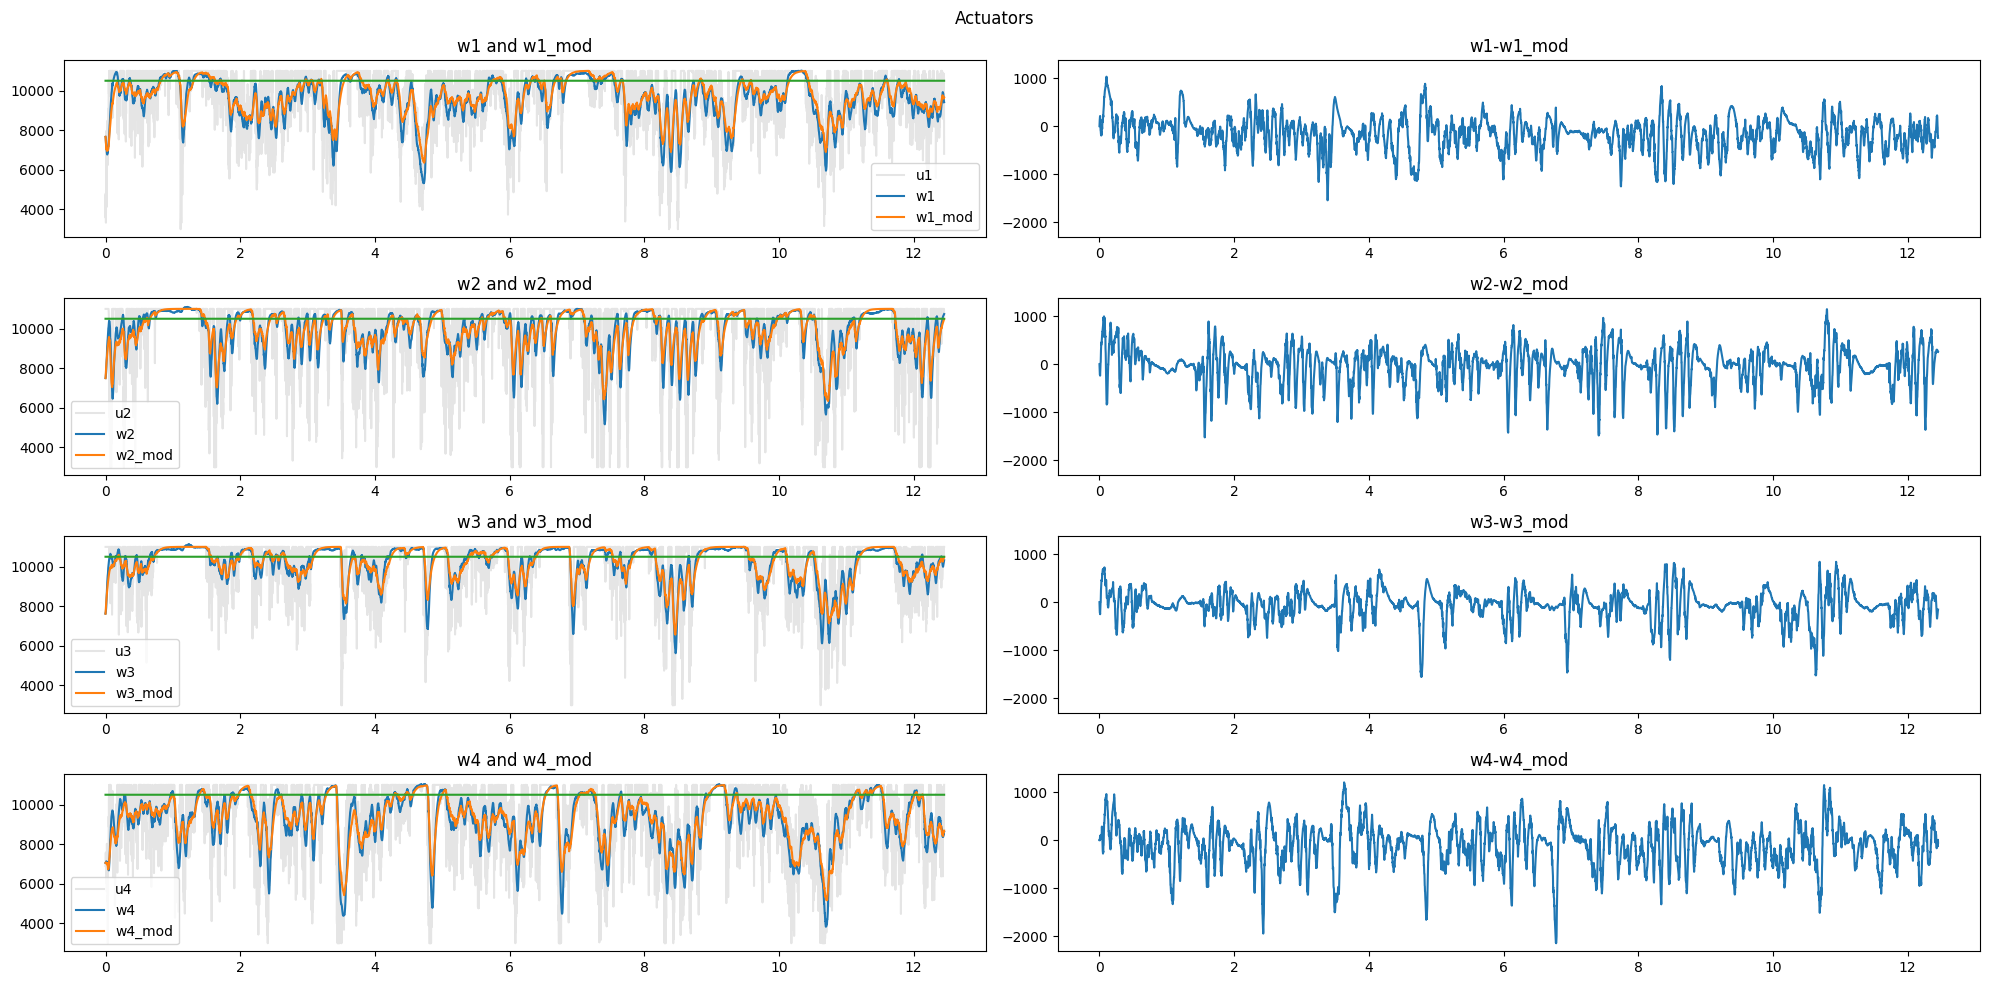

In [14]:
plot_actuators(log_autopilot)

## Improving the model

In [96]:
traj = log_autopilot
t = traj['t']-traj['t'][0]
d1 = traj['Mx_measured']-traj['Mx_modeled']
d2 = traj['My_measured']-traj['My_modeled']
d3 = traj['Mz_measured']-traj['Mz_modeled']
d4 = traj['Fz_measured']-traj['Fz_modeled']


In [ ]:
# Low frequency disturbance generator
def disturbance_generator(mean, std, length, cut_off, sampling_freq):
    x = np.random.randn(length)
    sos = signal.butter(4, cut_off, 'lp', fs=sampling_freq, output='sos')
    x = signal.sosfilt(sos, x)
    x = x/np.std(x)*std
    x = x + mean
    return x

print('mean:', np.mean(d1), 'std:', np.std(d1))
print('mean:', np.mean(d2), 'std:', np.std(d2))
print('mean:', np.mean(d3), 'std:', np.std(d3))
print('mean:', np.mean(d4), 'std:', np.std(d4))

d1g = disturbance_generator(0, 0.02, len(d1), 4., 500)
d2g = disturbance_generator(0, 0.03, len(d2), 4., 500)
d3g = disturbance_generator(0, 0.01, len(d3), 4., 500)
d4g = disturbance_generator(1.0, 1.20, len(d4), 4., 500)

# 4x1 subplots plotting di, dig against time
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs[0].plot(t, d1, label=r'$/delta$ M_x (real)')
axs[0].plot(t, d1g, label=r'$/delta$ M_x (generated)')
axs[0].set_title('M_x')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('M_x (Nm)')
axs[0].legend()
axs[1].plot(t, d2, label='$/delta$ M_y (real)')
axs[1].plot(t, d2g, label='$/delta$ M_y (generated)')
axs[1].set_title('M_y')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('M_y (Nm)')
axs[1].legend()
axs[2].plot(t, d3, label='$/delta$ M_z (real)')
axs[2].plot(t, d3g, label='$/delta$ M_z (generated)')
axs[2].set_title('M_z')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('M_z (Nm)')
axs[2].legend()
axs[3].plot(t, d4, label='$/delta$ F_z (real)')
axs[3].plot(t, d4g, label='$/delta$ F_z (generated)')
axs[3].set_title('F_z')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('F_z (N)')
axs[3].legend()
plt.show()


In [ ]:
def low_pass(x, sampling_freq, tau):
    y = np.zeros(len(x))
    for i in range(1, len(x)):
        y[i] = y[i-1] + (x[i] - y[i-1]) / (tau * sampling_freq)
    return y

x = d1g
plt.plot(t, x)
plt.plot(t, low_pass(x, 500, 1/8))
sos = signal.butter(1, 4., 'low', fs=500, output='sos')
plt.plot(t, signal.sosfilt(sos, x))
plt.xlim(0, 10)
plt.show()

In [ ]:
d_test = disturbance_generator(0, 1, len(d1), 4., 500)
plt.plot(t, d_test)
plt.xlim(0, 5)
plt.xlabel('Time [s]')
plt.show()